In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
import tensorflow as tf
from keras.optimizers import Adam
from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline
import glob
from keras.models import model_from_json
from keras.applications import imagenet_utils

from subprocess import check_output

# unet, img processing
# https://www.kaggle.com/ecobill/u-nets-with-keras

# fit_generator better understand
# https://medium.com/@fromtheast/implement-fit-generator-in-keras-61aa2786ce98

# fit_generator relevant issue
# https://github.com/fchollet/keras/issues/2702


# todo
# predict
# validation is from train also?
# https://www.kaggle.com/rdebbe/training-a-u-net-model-in-keras-theano

Using TensorFlow backend.


Let's prepare our data so that we can read it into our model. Since the data is super big we need a generator to read it a few at a time into memory.

# todo: image generator

In [2]:
# set the necessary directories
data_dir = "train/"
mask_dir = "train_masks/"
all_images = os.listdir(data_dir)

for file in glob.glob("*"):
    print(file)

metadata.csv
model_w_valid.h5
model_w_valid.json
test
test_hq
train
train_hq
train_masks
train_masks.csv
u-net-starter-1.py
Untitled.ipynb


In [3]:
# pick which images we will use for testing and which for validation
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

In [4]:
print(len(train_images))

4070


In [5]:
print(train_images[0])

2ea62c1beee7_11.jpg


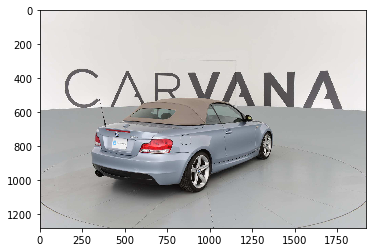

In [6]:
plt.imshow( load_img(data_dir + train_images[0] ) )


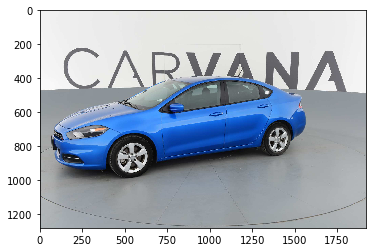

In [7]:
plt.imshow( load_img(data_dir + validation_images[0] ) )

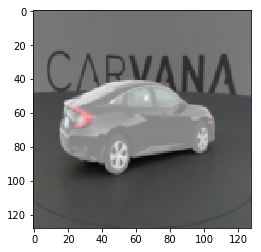

In [8]:
# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 5, [128, 128])
img, msk = next(train_gen)

val_gen = data_gen_small(data_dir, mask_dir, validation_images, 5, [128, 128])

plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

Now let's get started with making our actual network.

In [9]:
# First let's define the two different types of layers that we will be using.

def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2


In [10]:
# Make a custom U-nets implementation.
im_size = 128
filters = 64
input_layer = Input(shape = [im_size, im_size, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 128, 128, 64)  36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 64, 64, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [11]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [12]:
# other way of compile the model

# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# model.compile(Adam(lr=1e-3), dice_loss, metrics=['accuracy', dice_coef])

In [13]:
# should fitting contain validation data??? test it

In [29]:
# Training time!
# default : steps_per_epoch=100,epochs=10
# probably need to play around a little bit with the learning rate to get it to start learning
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])
model.fit_generator(train_gen, steps_per_epoch=100, epochs=10,
                    validation_data=val_gen,validation_steps = 100
                   )

# validation_data=val_datagen.flow(val_X, val_y, batch_size=BATCH_SIZE)


# serialize model to JSON
model_json = model.to_json()
with open("model_w_valid.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_w_valid.h5")
print("Saved model to disk")

Epoch 1/4
100/100 [==============================] - ETA: 198s - loss: 0.6924 - dice_coef: 0.507 - ETA: 110s - loss: 0.6860 - dice_coef: 0.310 - ETA: 80s - loss: 0.6802 - dice_coef: 0.207 - ETA: 65s - loss: 0.6752 - dice_coef: 0.15 - ETA: 55s - loss: 0.6698 - dice_coef: 0.12 - ETA: 51s - loss: 0.6638 - dice_coef: 0.10 - ETA: 49s - loss: 0.6551 - dice_coef: 0.08 - ETA: 47s - loss: 0.6513 - dice_coef: 0.07 - ETA: 45s - loss: 0.6413 - dice_coef: 0.06 - ETA: 44s - loss: 0.6338 - dice_coef: 0.06 - ETA: 43s - loss: 0.6247 - dice_coef: 0.05 - ETA: 41s - loss: 0.6203 - dice_coef: 0.05 - ETA: 40s - loss: 0.6106 - dice_coef: 0.04 - ETA: 40s - loss: 0.6023 - dice_coef: 0.04 - ETA: 39s - loss: 0.5909 - dice_coef: 0.04 - ETA: 38s - loss: 0.5820 - dice_coef: 0.03 - ETA: 37s - loss: 0.5755 - dice_coef: 0.03 - ETA: 36s - loss: 0.5658 - dice_coef: 0.03 - ETA: 36s - loss: 0.5545 - dice_coef: 0.03 - ETA: 35s - loss: 0.5513 - dice_coef: 0.03 - ETA: 35s - loss: 0.5442 - dice_coef: 0.05 - ETA: 34s - loss: 0

100/100 [==============================] - ETA: 24s - loss: 0.0764 - dice_coef: 0.93 - ETA: 24s - loss: 0.0782 - dice_coef: 0.93 - ETA: 23s - loss: 0.0841 - dice_coef: 0.92 - ETA: 22s - loss: 0.0823 - dice_coef: 0.92 - ETA: 22s - loss: 0.0792 - dice_coef: 0.92 - ETA: 22s - loss: 0.0776 - dice_coef: 0.92 - ETA: 21s - loss: 0.0753 - dice_coef: 0.92 - ETA: 21s - loss: 0.0749 - dice_coef: 0.92 - ETA: 21s - loss: 0.0745 - dice_coef: 0.92 - ETA: 21s - loss: 0.0727 - dice_coef: 0.92 - ETA: 20s - loss: 0.0729 - dice_coef: 0.92 - ETA: 20s - loss: 0.0712 - dice_coef: 0.93 - ETA: 20s - loss: 0.0708 - dice_coef: 0.93 - ETA: 20s - loss: 0.0696 - dice_coef: 0.93 - ETA: 19s - loss: 0.0712 - dice_coef: 0.93 - ETA: 19s - loss: 0.0700 - dice_coef: 0.93 - ETA: 19s - loss: 0.0700 - dice_coef: 0.93 - ETA: 19s - loss: 0.0696 - dice_coef: 0.93 - ETA: 19s - loss: 0.0693 - dice_coef: 0.93 - ETA: 18s - loss: 0.0701 - dice_coef: 0.93 - ETA: 18s - loss: 0.0697 - dice_coef: 0.93 - ETA: 18s - loss: 0.0690 - dice_co

# load model and weights

In [13]:
# load json and create model
json_file = open('model_w_valid.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_w_valid.h5")
print("Loaded model from disk")

# load_model('somefile', custom_objects={'x': x})

# evaluate loaded model on test data
loaded_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])


Loaded model from disk


# visualize a predicted image

In [14]:
# lets look at one of the predicted masks
img, msk = next(val_gen)
predicted_mask = loaded_model.predict(img)
predicted_mask.shape

(5, 128, 128, 1)

In [15]:
newshape = predicted_mask.swapaxes(1,3)
print('newshape shape ', newshape.shape)
grey = grey2rgb(newshape[3])
print('grey shape ', grey.shape)
plt.imshow(grey, alpha = 0.5)
plt.show()


newshape shape  (5, 1, 128, 128)


ValueError: cannot reshape array of size 49152 into shape (1,128,3)

# generator for test

In [ ]:
# more info on flow from dir, https://keras.io/preprocessing/image/
# load images to list?
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = test_datagen.flow_from_directory(
        'test/',
        target_size=(im_size, im_size),
        batch_size=300,
        class_mode=None) # todo test it

# generator that we will use to read the data from the directory
def test_gen_small(test_dir, images, batch_size, dims):
        """
        test_dir: where the actual test are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)

            imgs = np.array(imgs)
            yield imgs

# example use
test_gen = data_gen_small('test/', test_images, 5, [128, 128])
img = next(train_gen)



In [ ]:
import multiprocessing
num_workers = multiprocessing.cpu_count() - 2 # todo




# predict_generator(self, generator, steps, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)



loaded_mode.predict_generator(test_gen, 10, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
